<a href="https://colab.research.google.com/github/HowardHNguyen/Python/blob/main/Semantic_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the necessary datasets, install the necessary packages, and then import them to this project.

In [41]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define the function that will be used to transform images (tfms):

In [42]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

Define the dataset class by (SegData) function

Note: *In the __getitem__ method, we are resizing both the input (image) and output (mask) images so that they're the same shape. Note that the mask images contain integers that range between [0,11]. This indicates that there are 12 different classes.*

In [43]:
class SegData(Dataset):
      # Specify the folder that contains images in the __init__ method:
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
      # Define the __len__ method:
    def __len__(self):
        return len(self.items)
      # Define the __getitem__ method:
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
      # Define a function (choose) for selecting a random image index mainly for debugging purposes:
    def choose(self): return self[randint(len(self))]
      # Define the collate_fn method for performing prepocessing on a batch of images:
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In the preceding code, we are preprocessing all the input images so that they have a channel (so that each image can be passed through a CNN later) once we've transformed the scaled images. Notice that ce_masks is a tensor of long integers, similar to the cross-entropy targets.

In [44]:
# Define the training and validation dataets, as well as the dataloaders:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

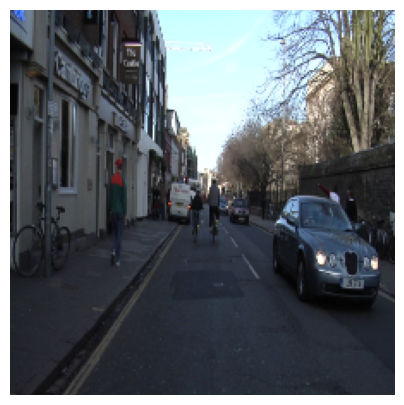

In [45]:
show(trn_ds[10][0])

In [46]:
# Define the neural network model by using the convolution block (conv):
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  # We are sequentially performing the Conv2d operation, the BatchNorm2d operation, and the ReLU operation.

In [47]:
# Define the up_conv block:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

ConvTranspose2d ensures that we upscale the images. This differs from the Conv2d operation, where we reduce the dimensions of the image. It takes an image that has in_channels number of channels as input channels and produces an image that has out_channels number of output channels.

In [48]:
# Define the network class - UNet:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
      # In this __init__ method, we are defining all the layers that we would use in the forward method.
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

  # In this code, we are making the U-style connection between the downscaling and upscaling convolution features
  # by using torch.cat on the appropriate pairs of tensors.

In [49]:
# Define a function (UNetLoss) that will calculate our loss and accuracy values:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [50]:
# Define a function that will train on batch (train_batch) and calculate metrics on the validation dataset (validate_batch):
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [53]:
# Define the model, optimizer, loss function, and the number of epochs:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

In [54]:
# Train the model over increasing epochs:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 1.206  val_acc: 0.765  val_loss: 0.875  trn_acc: 0.717  (18.42s - 902.81s remaining)
EPOCH: 2.000  trn_loss: 0.715  val_acc: 0.820  val_loss: 0.705  trn_acc: 0.819  (36.30s - 871.25s remaining)
EPOCH: 3.000  trn_loss: 0.582  val_acc: 0.866  val_loss: 0.564  trn_acc: 0.846  (54.49s - 853.65s remaining)
EPOCH: 4.000  trn_loss: 0.517  val_acc: 0.861  val_loss: 0.534  trn_acc: 0.861  (73.21s - 841.94s remaining)
EPOCH: 5.000  trn_loss: 0.472  val_acc: 0.859  val_loss: 0.553  trn_acc: 0.870  (91.33s - 821.93s remaining)
EPOCH: 6.000  trn_loss: 0.453  val_acc: 0.869  val_loss: 0.465  trn_acc: 0.874  (110.46s - 810.07s remaining)
EPOCH: 7.000  trn_loss: 0.416  val_acc: 0.857  val_loss: 0.460  trn_acc: 0.882  (128.67s - 790.42s remaining)
EPOCH: 8.000  trn_loss: 0.388  val_acc: 0.855  val_loss: 0.477  trn_acc: 0.889  (147.55s - 774.64s remaining)
EPOCH: 9.000  trn_loss: 0.374  val_acc: 0.860  val_loss: 0.455  trn_acc: 0.893  (165.85s - 755.53s remaining)
EPOCH: 10.000  

100%|██████████| 151/151 [00:00<00:00, 259.43it/s]


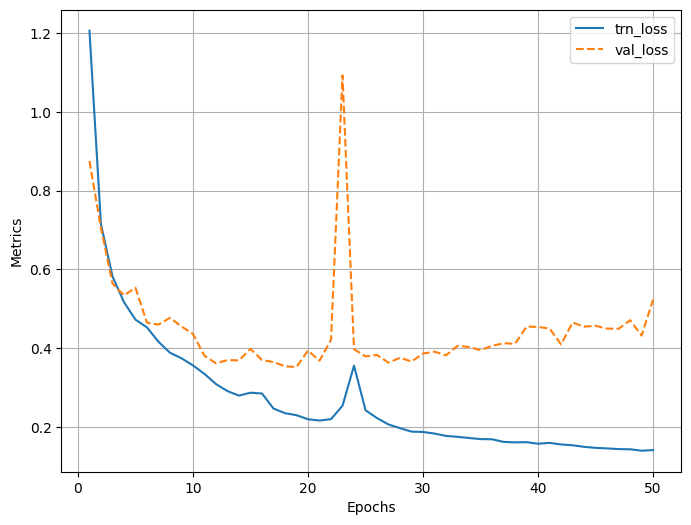

In [55]:
# Plot the training, validation loss, and accuracy values over increasing epoches:
log.plot_epochs(['trn_loss','val_loss'])

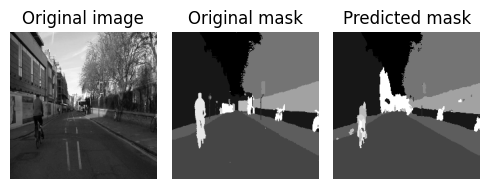

In [57]:
# Calculate the predicted output on a new image

  # Fetch model predictions on a new image
im, mask = next(iter(val_dl))
_mask = model(im)

  # Fetch the channel that has the highest probability
_, _mask = torch.max(_mask, dim=1)

  # Show the original and predicted images
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

From the picture, we can see that we can successfully generate a segmentation mask using the U-Net architecture from a given image from the validation dataset.

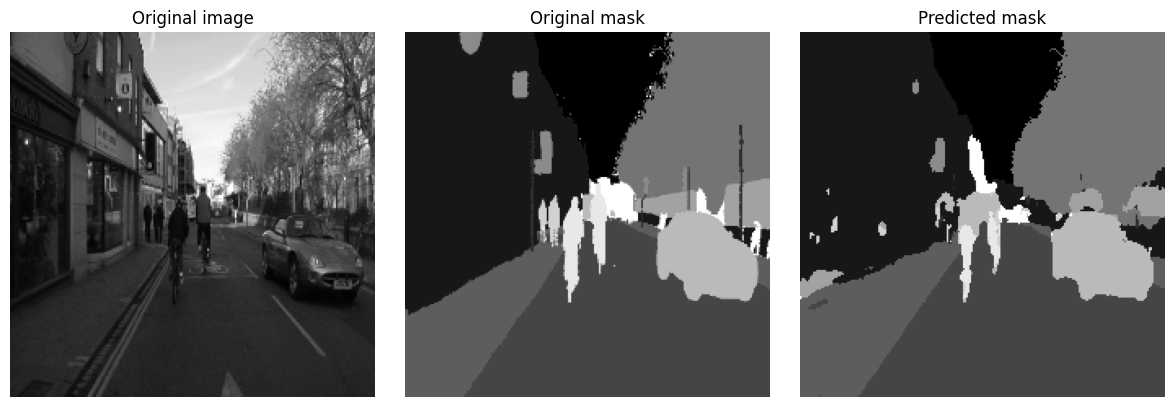

In [56]:
import matplotlib.pyplot as plt

# Define the figure size (adjust the numbers as needed)
plt.figure(figsize=(12, 4))

# Create subplots
plt.subplot(131)  # Original image
plt.imshow(im[0].permute(1, 2, 0).detach().cpu()[:, :, 0], cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(132)  # Original mask
plt.imshow(mask.permute(1, 2, 0).detach().cpu()[:, :, 0], cmap='gray')
plt.title('Original mask')
plt.axis('off')

plt.subplot(133)  # Predicted mask
plt.imshow(_mask.permute(1, 2, 0).detach().cpu()[:, :, 0], cmap='gray')
plt.title('Predicted mask')
plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()